# GravRay Plot Module

In [24]:
from gravray import *
from gravray.util import *

from matplotlib import pyplot as plt,colors
from mpl_toolkits.basemap import Basemap

In [20]:
%matplotlib nbagg

In [21]:
%matplotlib nbagg

In [9]:
%%javascript
IPython.notebook.kernel.execute('FILE="' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
class PlotGrid(object):
    """
    Class PlotGrid
    
    Create a grid of plots showing the projection of a N-dimensional
    
    Initialization attributes:
        dproperties: list of properties to be shown, dictionary of dictionaries (N entries)
            keys: label of attribute, ex. "q"
            dictionary: 
                label: label used in axis, string
                range: range for property, tuple (2)
        
    Optional initialization attributes:
        figsize=3 : base size for panels (the size of figure will be M x figsize), integer
        fontsize=10 : base fontsize, int
        direction='out' : direction of ticks in panels.
    
    Other attributes:
        N: number of properties, int
        M: size of grid matrix (M=N-1), int
        fw: figsize
        fs: fontsize
        fig: figure handle, figure
        axs: matrix with subplots, axes handles (MxM)
        axp: matrix with subplots, dictionary of dictionaries
        properties: list of properties labels, list of strings (N)
    
    Methods:
        tightLayout
        setLabels
        setRanges
        setTickParams
        
        plotHist
        scatterPlot
    """
    
    def __init__(self,properties,figsize=3,fontsize=10,direction='out'):

        #Basic attributes
        self.dproperties=properties
        self.properties=list(properties.keys())

        #Secondary attributes
        self.N=len(properties)
        self.M=self.N-1
        
        #Optional properties
        self.fw=figsize
        self.fs=fontsize

        #Create figure and axes: it works
        try:
            self.fig,self.axs=plt.subplots(
                self.M,self.M,
                constrained_layout=True,
                figsize=(self.M*self.fw,self.M*self.fw),
                sharex="col",sharey="row"
            )
            self.constrained=True
        except:
            self.fig,self.axs=plt.subplots(
                self.M,self.M,
                figsize=(self.M*self.fw,self.M*self.fw),
                sharex="col",sharey="row"
            )
            self.constrained=False
            
        #Create named axis
        self.axp=dict()
        for j in range(self.N):
            propj=self.properties[j]
            if propj not in self.axp.keys():
                self.axp[propj]=dict()
            for i in range(self.N):
                propi=self.properties[i]
                if i==j:
                    continue
                if propi not in self.axp.keys():
                    self.axp[propi]=dict()
                if i<j:
                    self.axp[propj][propi]=self.axp[propi][propj]
                    continue
                self.axp[propj][propi]=self.axs[i-1][j]
    
        #Deactivate unused panels
        for i in range(self.M):
            for j in range(i+1,self.M):
                self.axs[i][j].axis("off")
        
        #Place ticks
        for i in range(self.M):
            for j in range(i+1):
                self.axs[i,j].tick_params(axis='both',direction=direction)
        for i in range(self.M):
            self.axs[i,0].tick_params(axis='y',direction="out")
            self.axs[self.M-1,i].tick_params(axis='x',direction="out")
        
        #Set properties of panels
        self.setLabels()
        self.setRanges()
        self.setTickParams()
        self.tightLayout()
    
    def tightLayout(self):
        """
        Tight layout if no constrained_layout was used.
        
        Parameters: None
        
        Return: None
        """
        if self.constrained==False:
            self.fig.tight_layout()
            self.fig.subplots_adjust(wspace=self.fw/100.,hspace=self.fw/100.)
        
    def setTickParams(self,**args):
        """
        Set tick parameters.
        
        Parameters: 
            **args: same arguments as tick_params method, dictionary
        
        Return: None
        """
        opts=dict(axis='both',which='major',labelsize=0.8*self.fs)
        opts.update(args)
        for i in range(self.M):
            for j in range(self.M):
                self.axs[i][j].tick_params(**opts)
        
    def setRanges(self):
        """
        Set ranges in panels according to ranges defined in dparameters.
        
        Parameters: None
        
        Return: None
        """
        for i,propi in enumerate(self.properties):
            for j,propj in enumerate(self.properties):
                if j<=i:continue
                if self.dproperties[propi]["range"] is not None:
                    self.axp[propi][propj].set_xlim(self.dproperties[propi]["range"])
                if self.dproperties[propj]["range"] is not None:
                    self.axp[propi][propj].set_ylim(self.dproperties[propj]["range"])
    
    def setLabels(self,**args):
        """
        Set labels parameters.
        
        Parameters: 
            **args: common arguments of set_xlabel, set_ylabel and text, dictionary
        
        Return: None
        """
        opts=dict(fontsize=self.fs)
        opts.update(args)
        for i,prop in enumerate(self.properties[:-1]):
            label=self.dproperties[prop]["label"]
            self.axs[self.M-1][i].set_xlabel(label,**opts)
        for i,prop in enumerate(self.properties[1:]):
            label=self.dproperties[prop]["label"]
            self.axs[i][0].set_ylabel(label,**opts)
        for i in range(1,self.M):
            label=self.dproperties[self.properties[i]]["label"]
            self.axs[i-1][i].text(0.5,0.0,label,ha='center',
                                  transform=self.axs[i-1][i].transAxes,**opts)
            self.axs[i-1][i].text(0.0,0.5,label,rotation=270,va='center',
                                  transform=self.axs[i-1][i].transAxes,**opts)

        label=self.dproperties[self.properties[0]]["label"]
        self.axs[0][1].text(0.0,1.0,label,rotation=0,ha='left',va='top',
                              transform=self.axs[0][1].transAxes,**opts)

        label=self.dproperties[self.properties[-1]]["label"]
        self.axs[-1][-1].text(1.05,0.5,label,rotation=270,ha='left',va='center',
                              transform=self.axs[-1][-1].transAxes,**opts)

        self.tightLayout()
        
    def plotHist(self,data,colorbar=False,**args):
        """
        Create a 2d-histograms of data on all panels of the PlotGrid.
        
        Parameters: 
            data: data to be histogramed (n=len(data)), numpy array (nxN)
            
        Optional parameters:
            colorbar=False: include a colorbar?, boolean or int (0/1)
            **args: all arguments of hist2d method, dictionary
        
        Return: 
            hist: list of histogram instances.
        """
        opts=dict()
        opts.update(args)

        hist=[]
        for i,propi in enumerate(self.properties):
            for j,propj in enumerate(self.properties):
                if j<=i:continue
                h,xe,ye,im=self.axp[propi][propj].hist2d(data[:,i],data[:,j],**opts)
                hist+=[im]
                if colorbar:
                    #Create color bar
                    divider=make_axes_locatable(self.axp[propi][propj])
                    cax=divider.append_axes("top",size="7%",pad=0.1)
                    self.fig.add_axes(cax)
                    cticks=np.linspace(h.min(),h.max(),10)[2:-1]
                    self.fig.colorbar(im,
                                      ax=self.axp[propi][propj],
                                      cax=cax,
                                      orientation="horizontal",
                                      ticks=cticks)
                    cax.xaxis.set_tick_params(labelsize=0.5*self.fs,direction="in",pad=-0.8*self.fs)
                    xt=cax.get_xticks()
                    xm=xt.mean()
                    m,e=Util.mantisaExp(xm)
                    xtl=[]
                    for x in xt:
                        xtl+=["%.1f"%(x/10**e)]
                    cax.set_xticklabels(xtl)
                    cax.text(0,0.5,r"$\times 10^{%d}$"%e,ha="left",va="center",
                             transform=cax.transAxes,fontsize=6,color='w')

        self.setLabels()
        self.setRanges()
        self.setTickParams()
        self.tightLayout()
        return hist
                    
    def scatterPlot(self,data,**args):
        """
        Scatter plot on all panels of the PlotGrid.
        
        Parameters: 
            data: data to be histogramed (n=len(data)), numpy array (nxN)
            
        Optional parameters:
            **args: all arguments of scatter method, dictionary
        
        Return: 
            scatter: list of scatter instances.
        """
        scatter=[]
        for i,propi in enumerate(self.properties):
            for j,propj in enumerate(self.properties):
                if j<=i:continue
                scatter+=[self.axp[propi][propj].scatter(data[:,i],data[:,j],**args)]

        self.setLabels()
        self.setRanges()
        self.setTickParams()
        self.tightLayout()
        return scatter

In [25]:
from mpl_toolkits.basemap import Basemap,shiftgrid
from datetime import datetime

class Map(object):
    
    #warpimage
    #Valid: image="earth-map.jpg"
    image=None
    warpimage=dict(alpha=1)
    
    #lsmask
    drawlsmask=dict(land_color='coral',ocean_color='aqua',lakes=True)

    #Decoration atributtes
    drawmapboundary=dict(color='k',fill_color='aqua')

    #Parallels
    parallels=np.arange(-75,90,15)
    drawparallels=dict(labels=[1,1,0,0],labelstyle="+/-")

    almucantars=np.arange(0.0,90.0,15)
    drawalmucantars=dict(labels=[0,0,0,0],labelstyle="+/-",color='w')

    #Meridians
    meridians=np.arange(0,360,45.0)
    drawmeridians=dict(labels=[1,1,1,1],labelstyle="+/-",color='k')

    verticals=np.arange(0,360,30.0)
    drawverticals=dict(labels=[1,1,1,1],labelstyle="+/-",color='w')

    #Coastlines
    drawcoastlines=dict(linewidth=1,linestyle="solid",color='k')
    
    #Continents
    drawcontinents=dict(linewidth=1,linestyle="solid",color='k')

    #Countries
    drawcountries=dict(linewidth=1,linestyle="solid",color='k')

    #Fill continents
    fillcontinents=dict(color='coral',lake_color=None)

    #Nightshade
    date=datetime.utcnow()
    nightshade=dict(color='k',delta=0.25,alpha=0.5)
    
    def __init__(self,maptype,ax,**args):

        self.maptype=maptype
        self.ax=ax

        #Select type of map
        if maptype=="sky":
            #Other: projection='npaeqd'
            opts=dict(projection='npstere',boundinglat=0,resolution='l',lon_0=180)
            opts.update(args)
        elif maptype=="surface":
            opts=dict(projection='robin',resolution='c',lon_0=0)
            opts.update(args)            
        else:
            raise ValueError(f"Map type {maptype} not recognized")

        self.area=Basemap(**opts)
        self.mapopts=deepcopy(opts)
    
    def setDecoration(self):

        #Draw boundary
        if self.drawmapboundary is not None:
            self.area.drawmapboundary(ax=self.ax,**self.drawmapboundary)

        if self.maptype=="surface":
            #Draw meridians and parallels
            if self.drawparallels is not None:
                self.area.drawparallels(self.parallels,ax=self.ax,**self.drawparallels)
            if self.drawmeridians is not None:
                self.area.drawmeridians(self.meridians,ax=self.ax,**self.drawmeridians)

            #Background
            if self.image is not None:
                self.area.warpimage(ROOTDIR+"/data/"+self.image,**self.warpimage)
            elif self.drawlsmask is not None:
                self.area.drawlsmask(**self.drawlsmask)
            else:
                #Draw coastlines
                if self.drawcoastlines is not None:
                    self.area.drawcoastlines(ax=self.ax,**self.drawcoastlines)
                if self.drawcountries is not None:
                    self.area.drawcountries(ax=self.ax,**self.drawcountries)
                if self.fillcontinents is not None:
                    self.area.fillcontinents(ax=self.ax,**self.fillcontinents)
                #Night shade
                if self.nightshade is not None:
                    self.area.nightshade(self.date,ax=self.ax,**self.nightshade)
                    
        elif self.maptype=="sky":
            if self.drawalmucantars is not None:
                self.area.drawparallels(self.almucantars,ax=self.ax,**self.drawalmucantars)
            if self.drawverticals is not None:
                self.area.drawmeridians(self.verticals,ax=self.ax,**self.drawverticals)
            
            #Separate floor from sky
            fun=lambda lon,lat:1 if lat>0 else 0
            lons=np.linspace(0,360.0,100)
            lats=np.linspace(-30,90.0,100)
            cmap=colors.ListedColormap(['g','k'])
            self.contourFunction(fun,lons,lats,levels=[0,1],colors=['k'],lw=2)
            self.contourfFunction(fun,lons,lats,vmin=0,vmax=1,cmap=cmap)
                
    def contourFunction(self,function,lons,lats,**args):
        #Lat and lon mesh grid
        P=np.zeros((len(lons),len(lats)))
        for i,lon in enumerate(lons):
            for j,lat in enumerate(lats):
                P[i,j]=function(lon,lat)
        LONS,LATS=np.meshgrid(lons,lats)
        c=self.area.contour(LONS,LATS,P.transpose(),latlon=True,**args)
        return c

    def contourfFunction(self,function,lons,lats,**args):
        #Lat and lon mesh grid
        P=np.zeros((len(lons),len(lats)))
        for i,lon in enumerate(lons):
            for j,lat in enumerate(lats):
                P[i,j]=function(lon,lat)
        LONS,LATS=np.meshgrid(lons,lats)
        c=self.area.contourf(LONS,LATS,P.transpose(),latlon=True,**args)
        return c

--End--

# Snippets

<IPython.core.display.Javascript object>


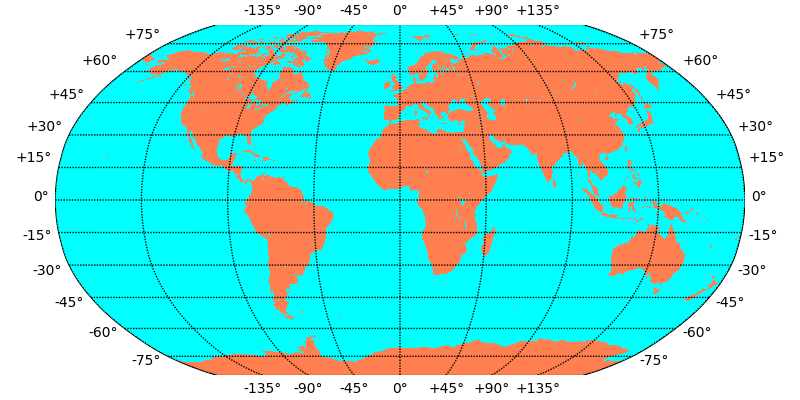

In [22]:
fig=plt.figure(figsize=(8,4),constrained_layout=True)
ax=fig.gca()
fig.clf()
ax=fig.gca()
m=Map("surface",ax,projection="robin")
m.setDecoration()

<IPython.core.display.Javascript object>


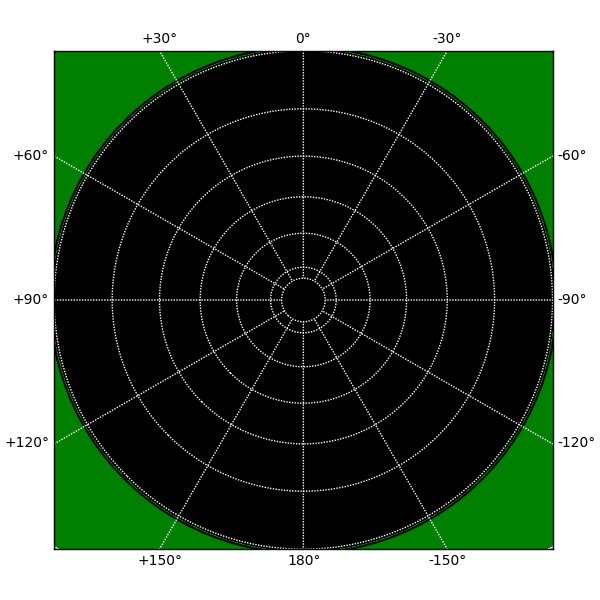

In [28]:
fig=plt.figure(figsize=(6,6),constrained_layout=True)
ax=fig.gca()
m=Map("sky",ax)
m.drawmapboundary.update(dict(fill_color=None))
m.setDecoration()

In [29]:
from gravray.stats import *

<IPython.core.display.Javascript object>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


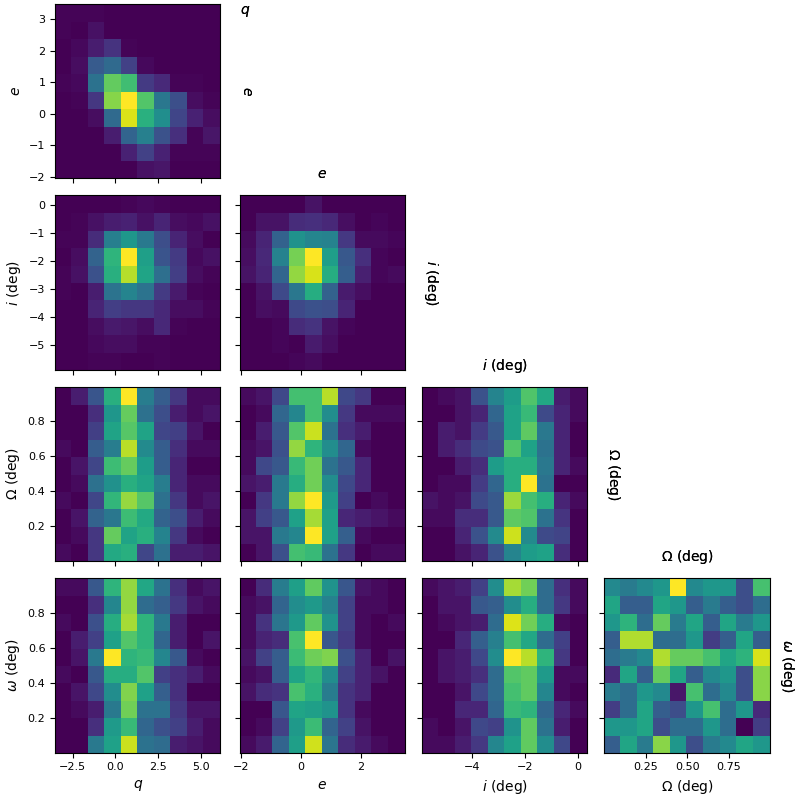

In [32]:
#We have a distribution of points in N-d
weights=[0.6]
locs=[
    [0.5,0.5,-2.0],
    [2.0,0.3,-2.6]
]
scales=[
    [1.3,0.7,0.5],
    [0.4,0.9,1.6]
]
angles=[
    [-40.0*Angle.Deg,-86.0*Angle.Deg,0.0*Angle.Deg],
    [+80.0*Angle.Deg,-109.0*Angle.Deg,0.0*Angle.Deg]
]
ranges=[
    [0.0,1.0],
    [0.0,1.0]
]
mnd=MultiVariate([1,1,1,0,0])
mnd.setUnflatten(weights,locs,scales,angles,ranges)
ps=mnd.rvs(1000)

properties=dict(
    q=dict(label=r"$q$",range=None),
    e=dict(label=r"$e$",range=None),
    i=dict(label=r"$i$ (deg)",range=None),
    W=dict(label=r"$\Omega$ (deg)",range=None),
    w=dict(label=r"$\omega$ (deg)",range=None),
)
G=PlotGrid(properties,figsize=2)
hist=G.plotHist(ps)
args=dict(c='r',s=0.1,alpha=1)

# Convert

In [33]:
!make -C .. DEVFILES=dev/{FILE} convert

Converting iPython Notebooks...
Analysing file gravray-plot.ipynb:
	Directory: ./gravray
	Filename: plot
	Target object: ./gravray/plot.py
	Converting from ipynb dev/gravray-plot.ipynb to python ./gravray/plot.py...
	Triming...
	Processing magic commands...
	Adding header...
Completed.
